In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import haversine as hs
import geopandas as gp
from shapely.geometry import MultiPoint, Point, Polygon
import numpy as np
from sklearn.cluster import DBSCAN
from shapely import wkt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from watertap3.truck_pipe_cost_functions import elevation
from IPython.display import clear_output

Find centroids of brackish water sites within 25 miles

Location of brackish water sites that satisfy conditions for selection of brackish wells

In [2]:
bw_df = pd.read_csv('/Users/mhardika/Documents/AMO/GeoToolAll_Methods/Water Source Data/Brackish/brackish_sites_with_metrics_baseline_dwi_updated_costs_transport_updated_basis.csv')

Create coordinates dataframa for all brackish wells

In [3]:
coords = bw_df[['Latitude', 'Longitude','state_alpha']]

Function to find the centroid

In [4]:
def find_centroid(coords,cluster_range = 25):
    kms_per_radian = 6371.0088
    range_km = cluster_range*1.609343502101154
    epsilon = range_km/ kms_per_radian

    db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
    cluster_labels = db.labels_

    # get the number of clusters
    num_clusters = len(set(cluster_labels))

    # turn the clusters in to a pandas series, where each element is a cluster of points
    clusters = pd.Series((coords[cluster_labels==n] for n in range(num_clusters)))
    centroids = []

    for ea in clusters:
        centroids.append((MultiPoint(ea).centroid.x, MultiPoint(ea).centroid.y))

    centroids = np.array(centroids)
    return [centroids,cluster_labels]

Go through each state and find centroid of brackish sites groups

In [46]:
bw_df_centroid = pd.DataFrame(columns= bw_df.columns)
cluster_df = pd.DataFrame(columns = ['cluster_labels','centroid'])

for state in ['AZ']:#bw_df['state_alpha'].unique():
    # print(state)

    coords_input = coords[coords['state_alpha']==state][['Latitude', 'Longitude']].to_numpy()
    centroids,cluster_labels = find_centroid(coords_input,10)

    loc = [Point(xy) for xy in zip(centroids[:,1],centroids[:,0])]
    loc = gp.GeoDataFrame(geometry = loc, crs='EPSG:4326')
    loc.geometry = loc.geometry.to_crs('EPSG:4326')

    # Assign cluster label
    temp = pd.DataFrame(columns = ['cluster_labels','centroid'])
    temp['cluster_labels'] = cluster_labels
    temp['centroid'] = loc.geometry[cluster_labels].values

    cluster_df= pd.concat([cluster_df,temp])
    cluster_df.reset_index()

    bw_df_centroid = pd.concat([bw_df_centroid,bw_df[bw_df['state_alpha']==state]])
    
bw_df_centroid = bw_df_centroid.assign(centroid = cluster_df['centroid'].values)
bw_df_centroid['cluster_id'] = pd.factorize(bw_df_centroid['centroid'])[0]


c:\Users\mhardika\miniconda3\envs\watertap3\lib\site-packages\geopandas\array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(


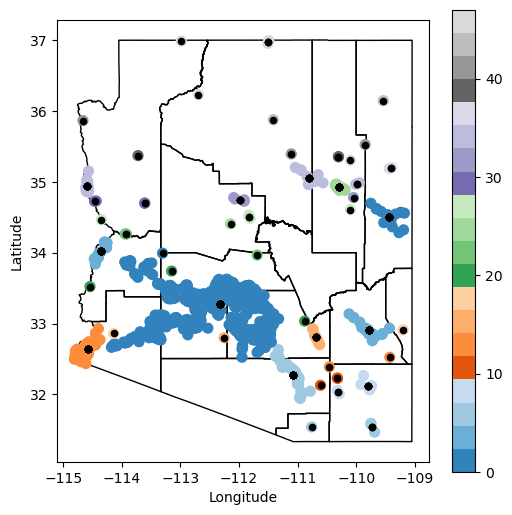

In [47]:
us_counties = gp.read_file(r'\Users\mhardika\Documents\AMO\GeoToolAll_Methods\GeoData\US_County_Boundaries\US_CountyBndrys.shp')
us_counties = us_counties.to_crs("EPSG:4326")

state_code = '04'
state = us_counties.loc[us_counties['STATEFP']==state_code]
state_alpha = 'AZ'

bw_long = bw_df_centroid[bw_df_centroid['state_alpha']==state_alpha]['Longitude']
bw_lat = bw_df_centroid[bw_df_centroid['state_alpha']==state_alpha]['Latitude']

bw_geometry = [Point(xy) for xy in zip(bw_long,bw_lat)]
bw_geo_df = gp.GeoDataFrame(geometry = bw_geometry, crs='EPSG:4326')
bw_geo_df.geometry = bw_geo_df.geometry.to_crs('EPSG:4326')

fig, ax0 = plt.subplots(figsize = (6,6))

# state.plot(ax=ax,facecolor ='none',edgecolor ='black')
# bw_geo_df.plot(ax=ax, color='blue',edgecolors='black' ,linewidth = 0.25, markersize = 15,label = "BW Sites")

state.plot(ax=ax0,facecolor ='none',edgecolor ='black')
# bw_geo_df.plot(ax=ax0, markersize = 15, edgecolors = 'black', c='blue',linewidth = 0.25, label = "BW Sites")

temp = bw_df_centroid[bw_df_centroid['state_alpha']==state_alpha]

temp.plot.scatter(ax=ax0 , x = 'Longitude', y = 'Latitude', c=temp['cluster_id'].values, s=50, cmap='tab20c')
ax0.scatter(temp['centroid'].values.x,  temp['centroid'].values.y, color = 'black',s=20)

# for cluster in bw_df_centroid[bw_df_centroid['state_alpha']==state_alpha]['cluster_id'].unique():
#     temp = bw_df_centroid[bw_df_centroid['state_alpha']==state_alpha][bw_df_centroid['cluster_id']==cluster]
#     ax0.scatter(temp['Longitude'], temp['Latitude'],s = 10)


In [48]:
# Calculating the distance to the centroid for all state

bw_df_centroid_1 = bw_df_centroid[bw_df_centroid['state_alpha']=='AZ'].copy()


dist= []
centroid_elev = []
well_elev = []

for i in bw_df_centroid_1.index:
    clear_output(wait=True)
    print(i, i/len(bw_df_centroid_1.index))
    bw_long = bw_df_centroid_1.loc[i]['Longitude']
    bw_lat = bw_df_centroid_1.loc[i]['Latitude']

    bw_loc = (bw_lat,bw_long)

    cent_long = bw_df_centroid_1.loc[i].centroid.x
    cent_lat = bw_df_centroid_1.loc[i].centroid.y

    cent_loc = (cent_lat,cent_long)

    dist_km = hs.haversine(cent_loc,bw_loc)

    dist.append(dist_km)
    centroid_elev.append(elevation(cent_lat,cent_long))
    well_elev.append(elevation(bw_lat,bw_long))


3244 1.9026392961876832


In [49]:
bw_df_centroid_1['dist_miles'] = dist
bw_df_centroid_1['centroid_elev'] = centroid_elev
bw_df_centroid_1['well_elev'] = well_elev
bw_df_centroid_1.head()

,unique_site_ID,state_alpha,county_nm,Latitude,Longitude,well_depth_ft,well_yield,TDS_kgm3,state,elec_price,...,recovery,capital,onm,elec_int,tds_out,centroid,cluster_id,dist_miles,centroid_elev,well_elev
0,AZ_GEOTH-AZ0183,AZ,Pinal,32.639722,-111.945833,682.0,0.031545,0.754442,Arizona,0.0628,...,92.866138,8.879727,0.314866,2.663241,0.056599,POINT (-112.32784 33.27086),0,78.711355,427.707184,462.576752
1,AZ_GEOTH-AZ0274,AZ,Pinal,32.850556,-111.584444,374.0,0.070667,2.841712,Arizona,0.0628,...,89.781082,16.424565,0.657947,2.740707,0.100763,POINT (-112.32784 33.27086),0,83.568271,427.707184,449.939636
2,AZ_GEOTH-AZ0297,AZ,Pinal,32.894444,-111.558611,3265.0,0.125000,2.888000,Arizona,0.0628,...,89.849854,25.566372,1.856132,6.058783,0.103629,POINT (-112.32784 33.27086),0,82.994701,427.707184,441.981445
3,AZ_GEOTH-AZ0327,AZ,Pinal,32.931111,-111.550000,2566.0,0.037854,9.120000,Arizona,0.0628,...,86.213229,11.191279,0.615273,6.376542,0.210457,POINT (-112.32784 33.27086),0,81.712292,427.707184,434.284180
4,AZ_GEOTH-AZ0338,AZ,Pinal,32.936944,-111.566944,3000.0,0.063000,1.901000,Arizona,0.0628,...,91.183172,14.827503,0.914241,5.555922,0.088042,POINT (-112.32784 33.27086),0,80.010955,427.707184,432.622864


In [50]:
path = r'\Users\mhardika\Documents\AMO\GeoToolAll_Methods\Water Source Data\Brackish'
bw_df_centroid_1.to_csv(path+r'\az_bw_lcow_dbscan.csv')